### Efficient Frontier

C:\Users\camil\AppData\Local\Temp\ipykernel_16768\246583405.py:151: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)
C:\Users\camil\AppData\Local\Temp\ipykernel_16768\246583405.py:151: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


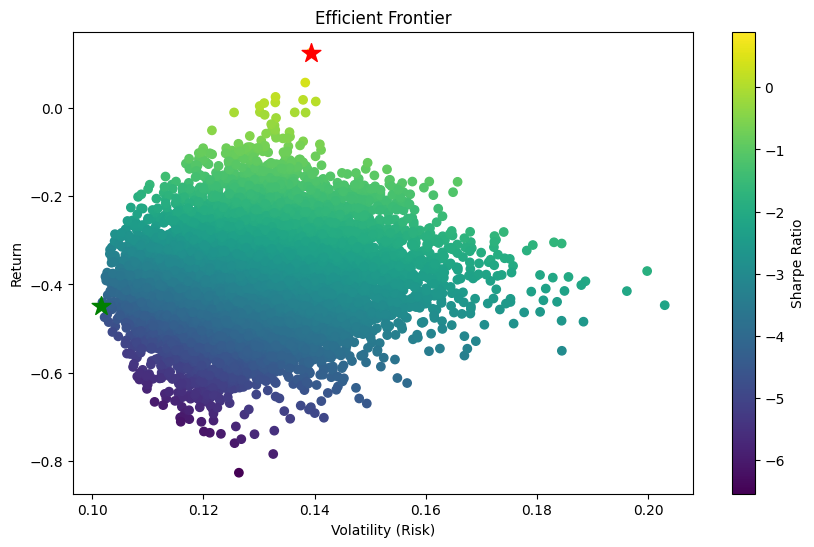

Optimal Portfolio Stats: 


,Return,Volatility,Sharpe
0,0.226897,0.152333,1.489476


Optimal max volatility and return: 0.13933397254695967, 0.12437209443927515

Stats: 


,apple,google,facebook,microsoft,amazon
expected_return,-0.003836,-0.001721,-0.001821,-0.001144,0.000900
variance,0.000082,0.000098,0.000234,0.000125,0.000092
standard_deviation,0.009078,0.009891,0.015283,0.011198,0.009596
variation_coefficient,-2.366356,-5.747547,-8.394867,-9.792071,10.657782
performance,-0.422591,-0.173987,-0.119120,-0.102123,0.093828
sharpe_index,-5.930670,-5.229127,-3.390704,-4.567245,-5.116620
beta,0.870758,1.198657,1.957056,1.441522,0.322668
n,19.000000,19.000000,19.000000,19.000000,19.000000


Optimal weights on each portfolio: 


,Companies,Weights
0,Apple,0.0
1,Google,0.0
2,Facebook,0.0
3,Microsoft,0.0
4,Amazon,100.0


In [5]:
# Importing 1st Party Libraries
import re
import math

# Importing 3rd Party Libraries
import urllib3
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress


def decoding(url: str):
    """The decoding function sends a request to the URL and it retrieves the HTML tags used to build front-end site."""

    # Importing methods for sending requests
    https = urllib3.PoolManager()

    # Sending HTTP request
    r = https.request('GET', url)

    # Returning string with HTML tags used for creating website
    return r.data.decode(encoding = 'UTF-8')

def headers(results: str):
    """As soon as the data has been decoded into string, through the use regular expressions the headers function looks for the html snippet, which is set within, to save and organize headers into a list."""

    # HTML tag
    pattern = r'<th class.*?>(.*?)</th>'
    
    # Switching HTML tag to regular expression
    regex = re.compile(pattern)

    # Finding elements with pattern
    results = regex.findall(''.join(results), re.IGNORECASE | re.DOTALL)

    # Instantiating empty list to store headers
    headers = []

    # Discarding divs from the source code
    for item in [i for i in results if i[0:4] != '<div'][:7:1]:
        # Removing comments from the request
        item = item.replace(' <!-- -->', '')
        headers.append(item)
        
    # Returning headers
    return headers

def date_values(results: str):
    """As soon as the data has been decoded into string, through the use regular expressions the date_values function looks for the html snippet, which is set within, to save and organize dates into a list."""
    
    # HTML tag
    pattern = r'<time .*?>(.*?)</time>'

    # Switching HTML tag to regular expression
    regex = re.compile(pattern)

    # Finding elements with pattern
    time = regex.findall(''.join(results), re.IGNORECASE | re.DOTALL)
    
    # Instantiating empty list to store dates
    date_list = []

    # Iterating through each result obtained from RegEx to save only dates and not hours
    for element in time:
        if element in re.findall(r'\d{2}:\d{2}:\d{2}', element):
            continue
        date_list.append(element)

    # Returning dates using list comprehension
    return [date for date in date_list if not len(date) < 10]

def open_vol_values(results: str, case: str):
    """As soon as the data has been decoded into string, through the use regular expressions the open_vol_values function looks for the html snippet, which is set within, to save and organize from Open to Vol. values from the URL into a list."""

    # HTML tag
    pattern = r'<td class="min-w-.*?>(.*?)</td>'

    # Switching HTML tag to regular expression
    regex = re.compile(pattern)

    # Finding elements with pattern
    open_values = regex.findall(''.join(results), re.IGNORECASE | re.DOTALL)
    
    # If the user has entered risk-free it will arrange values by each 3rd element
    if case == 'risk-free':
        return [open_values[i::4] for i in range(0, 4)]
    
    else:
        # Returning open values to be saved using list compregension
        return [open_values[i::4] for i in range(0, 4)]

def change_values(results: str):
    """As soon as the data has been decoded into string, through the use regular expressions the open_vol_values function looks for the html snippet, which is set within, to save and organize Change % values from the URL into a list."""

    # HTML tag
    pattern = r'datatable_cell__LJp3C datatable_cell--align-end__qgxDQ .*?>(.*?)</td>'
    
    # Switching HTML tag to regular expression
    regex = re.compile(pattern)

    # Finding elements with pattern
    values = regex.findall(''.join(results), re.IGNORECASE | re.DOTALL)

    # Percent generation using list comprehension
    percent_values = [[element for element in values if element[0:4] != '<div'][i] for i in range(1, len([element for element in values if element[0:4] != '<div']), 2)]

    # Price values generation using list comprehension
    price_values = [[element for element in values if element[0:4] != '<div'][i] for i in range(0, len([element for element in values if element[0:4] != '<div']), 2)]
    
    # Returning price values and percent lists
    return price_values, percent_values

def company_dataframe(url: str, case: str):
    """Takes the lists from the previous functions and it generates a new DataFrame."""

    # Instantiating empty list to store values and generating final DataFrame
    new_list = []

    # Sending request and getting source code
    results = decoding(url)

    # Obtaining price and change % values
    price_values, percent_values = change_values(results)
    
    # Appending dates on empty list
    new_list.append(date_values(results))
    
    # Appending next price values
    new_list.append(price_values)

    # Appending values in between such as Open, High, Low, Vol.
    for i in range(0, len(open_vol_values(results, case))):
        new_list.append(open_vol_values(results, case)[i])
    
    # Appending Change %
    new_list.append(percent_values)

    # Values are changed from rows to columns
    df = pd.DataFrame(new_list, index = None).transpose()
    
    # Setting headers
    df.columns = [header for header in headers(results) if header != 'Name']

    # Replacing possible commas
    df[['Price', 'Open', 'High', 'Low']] = df[['Price', 'Open', 'High', 'Low']].replace(',', '', regex =  True)

    # Replacing single quotes with np.nan
    df = df.replace('', np.nan)

    # Copying original DataFrame for creating condition
    df_test = df.copy()

    # Case applicable for the United States 10-Year Bond Yield Historical Data
    if 'Vol.' not in df_test.columns or df_test['Vol.'].isna().sum() > 0:
        df_test = df_test[['Open', 'High', 'Low']]    

    else:
        # Extracting columns where possible NaNs can be originated
        df_test = df_test[['Open', 'High', 'Low', 'Vol.']]

    # In case columns are empty, additional alternative to generate DataFrames is available
    if df_test.empty:
        # Sending request
        html = requests.get(url).content
        # Reading investing table and transforming it into a DataFrame
        df = pd.read_html(html)
        # Retrieving 2nd DataFrame
        df = df[1]
        # Changing Data Types
        df[['Price', 'Open', 'High', 'Low']] = df[['Price', 'Open', 'High', 'Low']].astype(float)
    
    else:
        # Changing Data Types
        df[['Price', 'Open', 'High', 'Low']] = df[['Price', 'Open', 'High', 'Low']].astype(float)

    # Returning DataFrame from the investing.com URL
    return df

def html_code(url: str):
    # Importing methods for sending requests
    https = urllib3.PoolManager()
    
    # Sending HTTP request
    r = https.request('GET', url)
    
    # String generation with HTML tags used for creating website
    results = str(r.data.decode(encoding = 'UTF-8'))

    # Writing code into a txt file
    with open('file.txt', 'w', encoding = 'UTF-8') as file:
        file.write(results)

def markowitz_calculations(urls: list, risk_free_rate: float):

    # Initializing empty lists and dictionaries
    df__ = {}
    header = []
    consolidating = []

    # https://tradingeconomics.com/united-states/interest-rate
    # 0.055

    # Extracting on each company the Price column
    for each in urls:
        header.append(each.split("/")[-1].split("-")[0])
        globals()[f'df__{each.split("/")[-1].split("-")[0]}'] = company_dataframe(each, 'not-risk-free')
        consolidating.append(globals()[f'df__{each.split("/")[-1].split("-")[0]}']['Price'])

    # Consolidating columns in a DataFrame and naming headers using the company name
    df_final = pd.concat(consolidating, axis = 1)
    df_final.columns = header

    # Copying 1st DataFrame, later on the original one will be modified
    df_final_ = df_final.copy()

    # Dropping the S&P Index
    df_final = df_final.drop('us', axis = 1)
    header.remove('us')

    # Calculating returns
    # df_return =  (df_final/df_final.shift()) - 1
    # df_final_ = (df_final_/df_final_.shift()) - 1
    df_return =  np.log(df_final/df_final.shift(1))
    df_final_ = np.log(df_final_/df_final_.shift(1))
    
    # Dropping empty rows
    df_final_ = df_final_.dropna(axis = 0, how = 'all')
    df_return = df_return.dropna(axis = 0, how = 'all')
    
    # After calculations are made, the mean is calculated on each portfolio
    df_standard = df_return.copy()
    df_standard_list = [df_standard[head].mean() for head in header]

    # Each value is substracted by its mean
    df_standard = df_standard - df_standard_list
    
    # Afterwards the variance is retrieved
    variance = [df_standard[head].var() for head in header]

    # Standard deviation is calculated as the squared root of the variance
    standard_deviation = [np.sqrt(variance) for variance in variance]

    # Covariance calculation
    df_covariance = pd.DataFrame((np.dot(df_standard.transpose(), df_standard)/(df_standard.shape[0] - 1)), index = header, columns = header)
    
    # Expected return is known as the mean price of every portfolio 
    expected_return = [df_return[head].mean() for head in header]
    
    # Counting items on each portfolio
    counts = [df_return[head].count() for head in header]

    # Obtaining variation coefficient
    variation_coefficient = [std / er for std, er in zip(standard_deviation, expected_return)]
    
    # Performance on each portfolio, shows profitability per point
    performance = [er / std for std, er in zip(standard_deviation, expected_return)]

    # Minimum limit to determine if the performance is lower than the risk free rate
    sharpe_index = [(er - risk_free_rate) / std for er, std in zip(expected_return, standard_deviation)]

    # Consists of obtaining the slope of each portfolio, considering the S&P 500
    beta = [linregress(df_final_['us'].tolist(), df_final_[name].tolist())[0] for name in [header for header in df_final_.columns if header != 'us']]
    
    # Summary of calculations retrieved
    stats = pd.DataFrame([expected_return, variance, standard_deviation, variation_coefficient, performance, sharpe_index, beta, counts], columns = header, index = ['expected_return', 'variance', 'standard_deviation', 'variation_coefficient', 'performance', 'sharpe_index', 'beta', 'n'])    
    
    # Correlation calculation
    correlation_matrix = df_covariance / np.dot(stats.filter(items = ['standard_deviation'], axis = 0).transpose(), stats.filter(items = ['standard_deviation'], axis = 0))

    return stats, df_covariance, df_final, correlation_matrix

def portfolio_returns_and_vols(urls: list, risk_free_rate: float):

    # Obtaining data required
    stats, df_covariance, df_final, *_ = markowitz_calculations(urls, risk_free_rate)

    # Multiplying returns and covariance with annualties
    expected_return = stats.loc['expected_return'] * 252
    df_covariance = df_covariance * 252

    # Initializing empty lists
    port_returns = []
    port_vols = []

    # Weights, returns and volume generation
    for i in range(10000):
        weights = np.random.random(len(df_final.columns))
        weights /= np.sum(weights)
        port_returns.append(np.sum(weights * expected_return))
        port_vols.append(np.sqrt(np.dot(weights.T, np.dot(df_covariance, weights))))

    # Switching lists into NumPy Arrays
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)

    return weights, port_returns, port_vols, expected_return, df_covariance

# List of URLs where the S&P500 must be the first one, cause it will be compared with the rest of the portfolio
urls = ['https://investing.com/indices/us-spx-500-historical-data',
        'https://www.investing.com/equities/apple-computer-inc-historical-data', 
        'https://www.investing.com/equities/google-inc-c-historical-data',
        'https://www.investing.com/equities/facebook-inc-historical-data',
        'https://www.investing.com/equities/microsoft-corp-historical-data',
        'https://www.investing.com/equities/amazon-com-inc-historical-data']

# Obtaining stats, covariance, df_final and correlation matrix
stats, df_covariance_, df_final, correlation_matrix = markowitz_calculations(urls, 0.05)

# Obtaining weights, portfolio returns, portfolio volume, expected return and covariance
weights, port_returns, port_vols, expected_return, df_covariance = portfolio_returns_and_vols(urls, 0.05)

# Obtaining allocations
sharpe = port_returns / port_vols
max_sr_returns = port_returns[sharpe.argmax()]
max_sr_volatility = port_vols[sharpe.argmax()]

# Portfolio statistics function
def portfolio_stats(weights, expected_return, df_covariance):
    port_return = np.sum(weights * expected_return)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(df_covariance, weights)))
    sharpe = port_return / port_vol
    return {'Return': port_return, 'Volatility': port_vol, 'Sharpe': sharpe}

# Minimize negative Sharpe ratio function
def minimize_sharpe(weights, expected_return, df_covariance):
    return -portfolio_stats(weights, expected_return, df_covariance)['Sharpe']

def portfolio_variance(weights, expected_return, df_covariance):
    return portfolio_stats(weights, expected_return, df_covariance)['Volatility']

def minimize_variance(stats, df_covariance_):
    num_assets = len(stats.loc['expected_return'])
    args = (stats.loc['expected_return'], df_covariance_)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(portfolio_variance, num_assets * [1. / num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)

    return result

# Initializer and bounds
initializer = len(df_final.columns) * [1. / len(df_final.columns)]
bounds = tuple((0, 1) for x in range(len(df_final.columns)))

# Optimization
optimal_sharpe = minimize(minimize_sharpe, initializer, args = (expected_return, df_covariance), method = 'SLSQP', bounds = bounds, constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
optimal_sharpe_weights = optimal_sharpe['x'].round(3)

# Obtaining optimal portfolio stats
optimal_stats = portfolio_stats(optimal_sharpe_weights, expected_return, df_covariance)

min_var = minimize_variance(stats, df_covariance_)

mean_returns = stats.loc['expected_return']

sdp_min = portfolio_stats(min_var['x'], expected_return, df_covariance)['Volatility']

rp_min = portfolio_stats(min_var['x'], expected_return, df_covariance)['Return']

# Plotting the efficient frontier
plt.figure(figsize = (10, 6))
plt.scatter(port_vols, port_returns, c = port_returns / port_vols, marker = 'o', cmap = 'viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(max_sr_volatility, max_sr_returns, c = 'red', marker = '*', s = 200, label = 'Optimal Sharpe')  # Optimal Sharpe ratio portfolio
plt.scatter(sdp_min, rp_min, marker = '*', c = 'green', s = 200, label = 'Min Variance')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.show()

# Summary - Optimal Stats
print("Optimal Portfolio Stats: ")
display(pd.DataFrame(optimal_stats, index = [0]))

# Obtaining max volatility and return
print(f"Max volatility and return: {max_sr_volatility}, {max_sr_returns}\n")

# Obtaining min volatility and return
print(f"Min volatility and return: {sdp_min}, {rp_min}\n")

# Stats
print("Stats: ")
display(stats)

# Optimal weights recommended on each portfolio
print("Optimal weights on each portfolio: ")
display(pd.DataFrame(list(zip([company.capitalize() for company in df_final.columns], optimal_sharpe_weights * 100)), columns = ['Companies', 'Weights'], index =  None))

[*********************100%%**********************]  4 of 4 completed


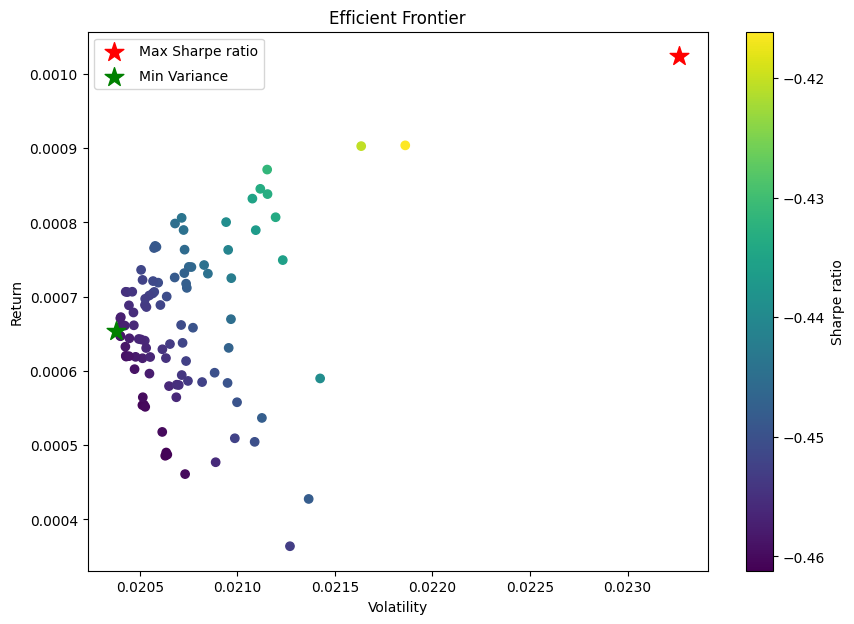

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Example tickers
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Adj Close']

returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def portfolio_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def minimize_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(portfolio_variance, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)

        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)

        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

        weights_record.append(weights)

    return results, weights_record

def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate):
    results, _ = efficient_frontier(mean_returns, cov_matrix)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_performance(max_sharpe['x'], mean_returns, cov_matrix)

    min_var = minimize_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_var['x'], mean_returns, cov_matrix)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe ratio')

    plt.scatter(sdp, rp, marker='*', color='r', s=200, label='Max Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=200, label='Min Variance')

    plt.legend(labelspacing=0.8)
    plt.show()

risk_free_rate = 0.01  # Example risk-free rate
plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

In [ ]:
df = pd.DataFrame({'Hello': frontier_x, 'World': frontier_y})

In [ ]:
df.to_excel('file.xlsx', index = None)